In [1]:
import pandas as pd # data analysis/wrangling
import numpy as np # math if required

from scipy import stats # stat tests
from statsmodels.graphics.gofplots import qqplot ## qq plots to assess normality

import matplotlib.pyplot as plt # visuals
import seaborn as sns # visuals

In [2]:
#import data
data = pd.read_csv('/home/sbangarh/AB_cookie_cats/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Data Overview

In [8]:
#get info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [9]:
#check for nulls
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [10]:
#check for duplicates
data.duplicated().sum()

0

No duplicates or nulls :)

# Exploratory data analysis

In [3]:
#convert userid to str - won't interfre wtih numeric analysis
data['userid'] = data['userid'].astype(str)

#change retention_1 and retention_7 to 0/1 boolean
bool_dict = {True: 1, False: 0}
data[['retention_1', 'retention_7']] = data[['retention_1', 'retention_7']].map(bool_dict.get)

#check work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.4+ MB


In [17]:
#summary stats
data.describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


In [18]:
#summary stats for categorical data
data.describe(include='O')

,userid,version
count,90189,90189
unique,90189,2
top,116,gate_40
freq,1,45489


Let's explore some visuals

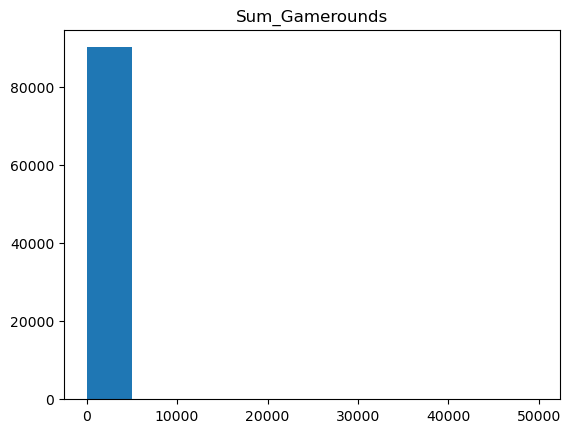

In [20]:
#game_rounds
plt.hist(data['sum_gamerounds'])
plt.title('Sum_Gamerounds')
plt.show()


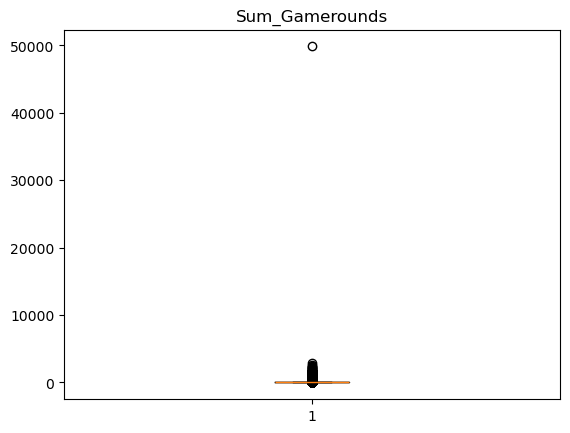

In [21]:
#boxplot for gamerounds
plt.boxplot(data['sum_gamerounds'])
plt.title('Sum_Gamerounds')
plt.show()

- gamerounds will need to be binned or transformed (log most likely)


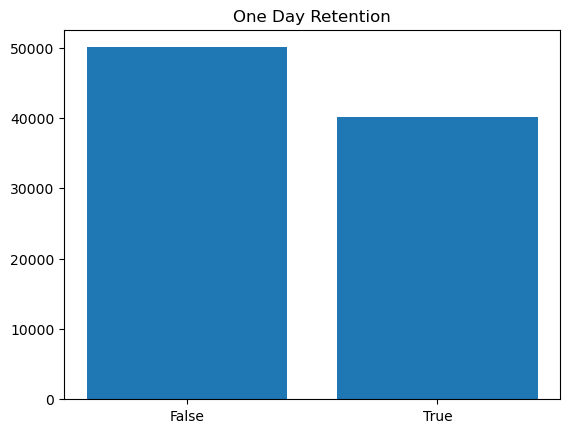

In [10]:
# get counts
retention_1_counts = data['retention_1'].value_counts()

#plot counts
plt.bar(retention_1_counts.index, retention_1_counts.values)
plt.title('One Day Retention')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

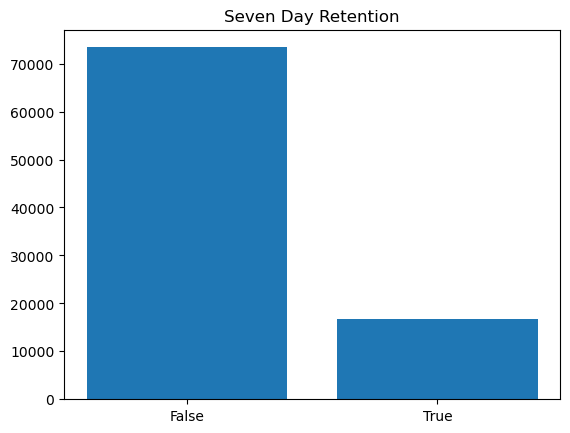

In [12]:
# get counts
retention_7_counts = data['retention_7'].value_counts()

#plot counts
plt.bar(retention_7_counts.index, retention_7_counts.values)
plt.title('Seven Day Retention')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

There appears to be a significant discrepancy between retention rates for one day and seven days.

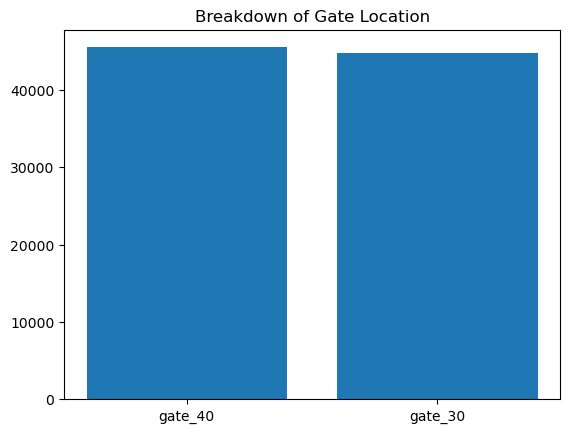

In [14]:
#breakdown of gate version
gate_counts = data['version'].value_counts()

#plt bar
plt.bar(gate_counts.index, gate_counts.values)
plt.title('Breakdown of Gate Location')
plt.show()

approximately even

Explore bivariate relations

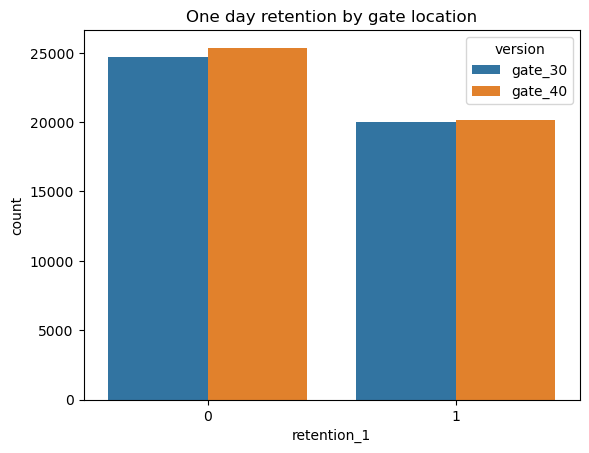

In [16]:
#retention by gate
sns.countplot(data=data, x='retention_1', hue='version')
plt.title('One day retention by gate location')
plt.show()

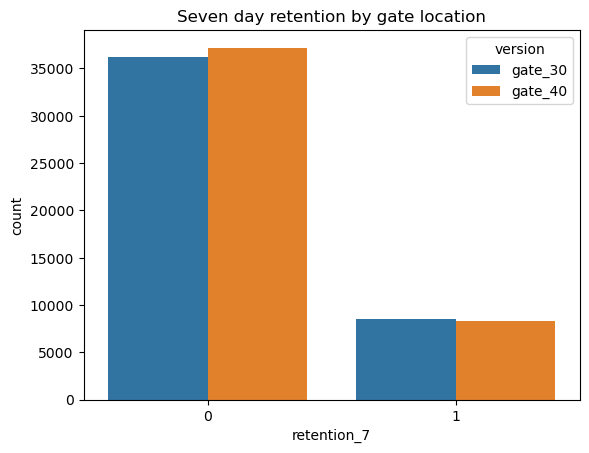

In [17]:
#retention by gate
sns.countplot(data=data, x='retention_7', hue='version')
plt.title('Seven day retention by gate location')
plt.show()

The drop off for seven days is significant for both gates...

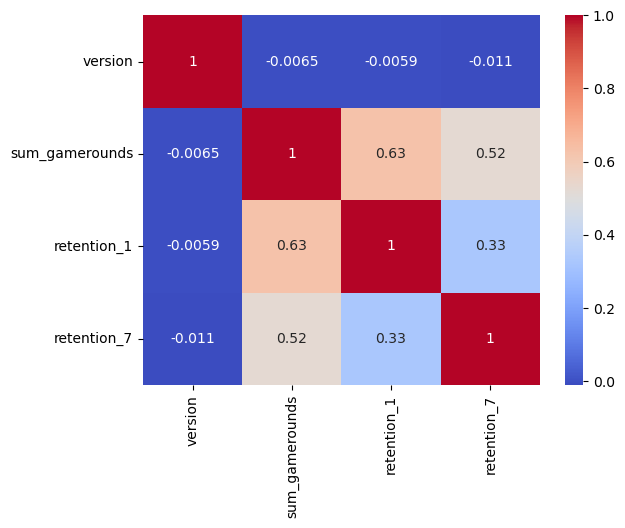

In [20]:
#factorize version feature and look at correlation
factorized_df = data.copy()
factorized_df['version'] = pd.factorize(factorized_df['version'])[0]

#get correlation and heatmap
corr = factorized_df[['version', 'sum_gamerounds', 'retention_1', 'retention_7']].corr('spearman') #use spearman because data not normal
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

game rounds are correlated with both retention metrics, while version is not (may need a test to confirm). Both retentions are mildly correlated with each other.